# Plate Reader Data Analysis

In our search for a mutant of *$\beta$-galactosidase* that is most efficient for hydrolysis of a phenol ester of galactose (and so perhaps effective at catalyzing the reverse esterification) we have perfromed a series of enzyme kinetics runs using a plate reader. The general methodology is described in the document that accompanies this notebook.

## The Multiwell Plates

We have 13 plates that were used. The contents of each well are documented in the plate plan files. These files are found in the `plateplan` folder and are named as `plateXX.csv`. Examone the contents of the folder to see the scheme for naming the files. Examine the contents of a file to familarize yourself with the format.

In each plan the 12 columns each contain a given concentration of an enzyme and each row contains a given concentration of substrate. That gives us 96 sets of absorbance vs time data for each plate. 

## The Plate Plan

Software tools have been written be another member of your research group. They are clunky, inefficient and badly organized. But, they work and everything they do can be understood by inspecting the code. We will use them as-is. 

The plate plans are collected in the `data1/plateplans/` folder. If we want to examine the data for plate #1 we would use the file name `Plate01,csv`. Take note of any capitalization in files names. Examine the code below and observe that the `read_plate_setup()` function in the `BiochemToolbox` library is being used.

The `read_plate_setup()` function takes a file path name (the plate plan file) and a pH value and returns a dataframe containing the data in the file, a dictionary of lists containing the same data and the calculated molar extinction coefficient for  p-nitropheno at the given pH value.

In [1]:
### Read in experimental parameters from plate plan file
### Create lists of column & row names, enzyme names, enzyme & substrate conc 
### Convert units to standard units (molar and min^-1)
### Calculate e_405 for nitrophenol at given pH

import pandas as pd
#!wget https://raw.githubusercontent.com/blinkletter/StealThisCode/main/BiochemToolbox.py
#!pip install uncertainties  # to install 'Uncertainties' package in Colab. 
import BiochemToolbox as BT
import numpy as np

file_location = "data1/plateplans/"
file_name = "Plate00.csv"
pH = 7.0

df, plate, e_NPA = BT.read_plate_setup(file_location+file_name, pH)

print(plate.keys())
print(df)


dict_keys(['row_name_list', 'S_conc_list', 'lane_name_list', 'E_conc_list', 'E_Name_list'])
    Column Enzyme  E_Conc  Row  S_Conc
0        1  Blank    0.00    A   0.005
1        2  Blank    0.00    B   0.010
2        3  Blank    0.00    C   0.020
3        4    wt1    1.00    D   0.030
4        5    wt1    1.00    E   0.060
5        6    wt1    1.00    F   0.100
6        7    wt1    0.50    G   0.200
7        8    wt1    0.50    H   0.500
8        9    wt1    0.50  NaN     NaN
9       10    wt1    0.25  NaN     NaN
10      11    wt1    0.25  NaN     NaN
11      12    wt1    0.25  NaN     NaN


## The Data

The data for each well in each plate is store in the `data` folder. Examine this folder. You will see 1248 data files representing 8 substrat concentrations in 156 enzyme kinetics experiments. Some of these data are blanks but most will be enzyme kinetic runs.

Each file has the format `PlateXX_YY_Z.csv` where `XX` is the plate number (00, 01, ... 11, 12), `YY` is the lane number in each plate (1, 2, ... 11, 12) and `Z` is the row label (A, B, ... G, H). This file naming system will allow us to match the plate plan to the data file.

The `contact_sheet()` function in the code below will plot the data from each well. The lanes are assumed to each contain a single kinetic run of eight different substrate concentrations. So the `contact_sheet()` function will collect the 96 data files associated with a given plate plan and make a plot of aborbanve vs time for ezch lane. Each plot will contain the data from the eight wells in the lane. A contact sheet of the 12 plots will be produced so that you can quickly visualize the quality of the results. tge lane number and lable (usually the name of the enzyme in each lane) will be printed on each plot.

The `contact_sheet()` function takes the path to the file (use the `PlateXX` portion of the file name as shown in the code below). The funtion will append the rest of the file name as it iterates through the data files. The function also requires a list of labels for the lanes and a list of labels for the rows. These labels are used in generating the files names and so must conform to the file naming scheme. e.g. values of 1 through 12 for lanes and A through H for rows. and the labels for the enzymes in each lane. A list of enzyme names is optional and, if used, will proved the text to label each plot with the enzyme. Finally a flag may be provided to toggle whether a style sheet is applied to the plot or the default style is used.

In [ ]:
### Contact sheet. Ticks deleted on plots inside the set.
#!wget https://raw.githubusercontent.com/blinkletter/StealThisCode/main/BiochemToolbox.py
#!pip install uncertainties  # to install 'Uncertainties' package in Colab. 
import BiochemToolbox as BT

BT.contact_sheet("data1/data/Plate00", 
                 columns = plate["lane_name_list"],
                 rows = plate["row_name_list"],
                 enzymes = plate["E_Name_list"],
                 fancy = True)

Plot saved as plots/plot_contact_sheet_00.pdf


0     Blank
1     Blank
2     Blank
3       wt1
4       wt1
5       wt1
6       wt1
7       wt1
8       wt1
9       wt1
10      wt1
11      wt1
Name: Enzyme, dtype: object

## Initial Rate Method

We could curve-fit the data to the integrated first order rate equation or the integrated Michaels-Menten equation however many of the data sets do not approach completion. We could still perform such curve fits if we were certain of the final absorbance value in each cell (and we should know that value).

The standard method in the field is to use the initial rate method. Here we will use data from the first fraction of the reaction where the change in absornace vs. time is almost linear. As the reaction progresses, we will see the line curve over on its way to never quite reaching the maximum value. What is an appropriate fraction of the time frame to use as the data that approximates the initial rate. Should we use the first 5%, 15% 50% - or some other value?

The `plot_six_w_residuals()` function in the `BiochemToolbox` library will take a plate name (e.f. Plate04) and append a lane and row label to access one of the data sets in the `data` folder. For example we could access the data file `Plate04_5_E.csv` by setting the lane label to "5" and the row label to "E". You can obtain information about the enzyme and substrate concentration from the corresponding plate plan file.

The `plot_six_w_residuals()` function also requires two fractional values of the time frame and will plot both in addition to the full data set. You can also set a destination file name that will be appended with the lane and row labels. You can also set the flag to select default plot style or use a style sheet.

Use the code below to explore some data sets. You will see that when the reaction is slow (i.e. when no enzyme is present) we need longer time frames to get a slope with acceptable precission. Examine the residual plots for deviations from the linear model. if your time frame is too long yopu will see a curved derivative plot. How curved is too curved? That's up to you, but always document your choices.

I have found that for the data sets that contain enzyme we see enough activity to use the first 5% of the time span. For cells that are very slow (uncatalyzed blanks mostly) we need more time. This information will be needed in making decisions as we move forward.

All slope = 0.00141 +/- 1.85e-06, r2 = 0.999
Med slope = 0.00142 +/- 2.69e-05, r2 = 0.982
short slope = 0.00149 +/- 0.000138, r2 = 0.885


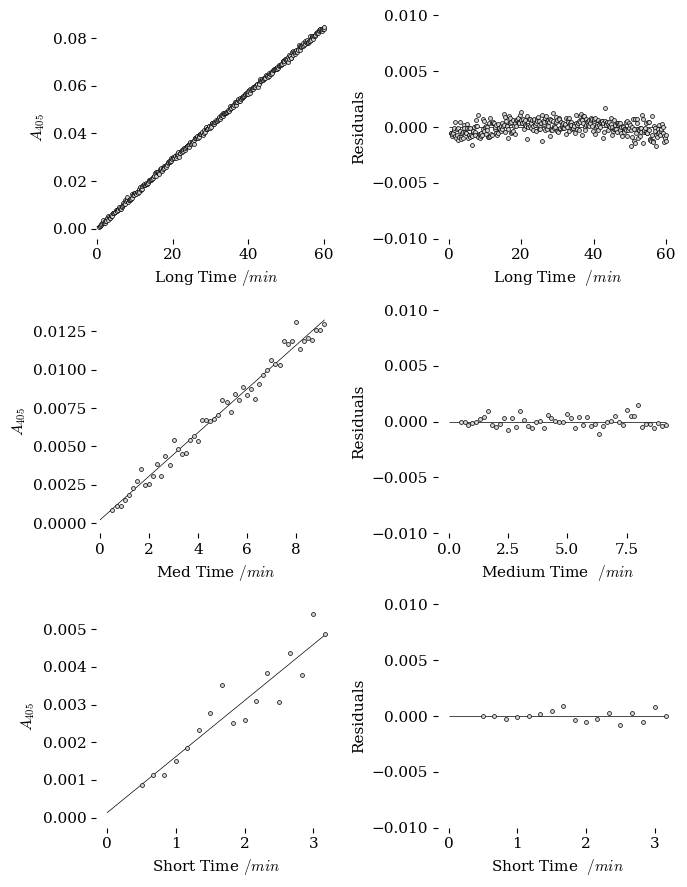

Plot saved as plot1/Cell_w_residuals_5_E.pdf


In [1]:
import BiochemToolbox as BT

data_name = "data1/data/Plate06"
lane_name = "5"
row_name = "E"

BT.plot_six_w_residuals(data_name, lane_name, row_name, 
                         Fraction_time_span_medium = 0.15,
                         Fraction_time_span_short = 0.05,
                         plot_file = "plot1/Cell_w_residuals",
                         fancy=True)

## Analyzing Data

When we have decided on a time range to use for the data we can run an anlysis of the initial slope of each well in all of our plates. This will be 1,248 line fits. If you want to do that in *Microsoft Excel* you will end up programming in *Visual Basic*, so why not just start with *Python* and stick with it.

Below we use two functions from the `BiochemToolbox` library. The first is `read_plate_setup()`, which will read in the data from the plate plan and return a dataframe that contains the information from the plate plan for a given plate plan file. All the plates use the same labels for lanes and rows so we can use this function to get the list of labels that describes the data files. The `read_plate_setup()` function also returns a value for the molar extinction coefficient of p-nitrophenol at the give pH value. We don't need that right now but we'll get it anyway because the function returns it every time. Feel free to improve the code.

In the code below we use the lane and row labels along with a list of plate names to access the data files using the `plot_wells()` function. This information is combined with the path to the data directory to create a path to each data file. For example, lane 3, column "G" of plate 2 in the data directory `data1/data/` is accessed as `data1/data/Plate02_3_G.csv` This function has many other inputs controlling the time spane, whether plots are generated and where they are saved, whether the analysis data is written to a file and the name of the data file, and some style controls for the plots. 

The `plot_wells()` function will iterate through the nested lists of plate names, lanes and rows. The function returns a dataframe with the analysis data and can save the output to a `.csv` file (if that is selected.)

In [ ]:
import BiochemToolbox as BT

### get plate info from a plate plan file
df, plate, e_NPA = BT.read_plate_setup("data1/plateplans/Plate02.csv", pH = 7.0)
#display(df)

### Chose columns to plot
Column_list = [2,3,4,5,6,7,8,9,10,11,12]  # Drop the first lane, lane #1 is the blank.
#print(Column_list)

### Chose rows within the columns
Row_list = df["Row"].dropna()      # All the plates have same row labels
#print(Row_list)

plate_name_list = ["plate01", "plate02", "plate03",
                    "plate04", "plate05", "plate06",
                    "plate07", "plate08", "plate09",
                    "plate10", "plate11", "plate12", 
                    ]
#plate_name_list = ["plate00"]    # Plate 00 is different than the rest

data_file_path = "data1/data/"

result = BT.plot_wells(data_file_path, plate_name_list, Column_list, Row_list, 
                       Fraction_time_span = .05,
                       Save_Data = True,
                       result_file_path = "data1/analysis_results",
                       Make_Plots = False,
                       plot_file_path = "plots/analysis_plot_",
                       fancy = True,
                       tiny_points = False,
                       tiny_line = False
                       )

display(result)

Data saved as data1/analysis_results.csv


,Plate,Column,Row,slope,slope stderr,int,int stderr,RSQ
0,plate01,2,A,0.001900,0.000132,0.000227,0.000265,0.932375
1,plate01,2,B,0.003796,0.000129,-0.000288,0.000258,0.983021
2,plate01,2,C,0.006213,0.000124,0.000331,0.000248,0.994102
3,plate01,2,D,0.008505,0.000158,-0.000047,0.000317,0.994867
4,plate01,2,E,0.012680,0.000135,-0.000004,0.000270,0.998309
...,...,...,...,...,...,...,...,...
1051,plate12,12,D,0.006439,0.000157,0.000468,0.000315,0.991160
1052,plate12,12,E,0.010969,0.000098,0.000623,0.000196,0.998815
1053,plate12,12,F,0.015176,0.000158,0.000400,0.000316,0.998386
1054,plate12,12,G,0.021073,0.000115,0.000544,0.000231,0.999554


## MM Curve Fits

We now have a data set of slopes for every well that was selected via the plate, lane and row lists above. We will now use the same lists to access the data and groupthe rows each lane of a plate to create data sets of rate (in micromolar per minute) vs substrate concentration for each enzyme. We can then curve fit the data against the Michaelis-Menten equation. We can weight the data using the standard error for the rates or not. We will obtain values of kcat, KM and kcat/KM. 

This could have all been done within the `plot_wells()` function as we are going to need to repeat all the same iterations here. However, I did it this way. Feel free to improve this workflow.

In [ ]:
# WRITE NEW CODE

import uncertainties as un
from uncertainties import unumpy as unp

from scipy.optimize import curve_fit      ## import tools
import numpy as np                       
from matplotlib import pyplot as plt     
import pandas as pd
from sklearn.metrics import r2_score

def collect_lanes(data_file_path, plate_name_list, Column_list, Row_list,
               Fraction_time_span = 1,
               Make_Plots = False, 
               plot_file_path = "plots/analysis_plot_",
               result_file_path = "data1/results/analysis_results_",
               fancy = False, tiny_points = False, tiny_line = False):

    """Determines slope of initial rate in each cell given time fraction.

    Will make a plot of all the wells designated by columns and rows
    Will fit data to linear curve fit and collect slopes and intercept data
    Will save the plot as a pdf
    Will save the data as a separate for each lane with same filename as pdf
    
    Arguments
    ---------
    data_file_name: string
        The data file name. Filenames will be this plus column and row
        e.g. "name_10_C.csv"
    Column_list, Row_list: Array like
        list of names for column, row to be plotted.
        Will usually be one column and some rows but can be as many as wanted
    Fraction_time_span: float
        The fraction of the time span to plt. Default is 1 for 100%
    Line_Fit: boolean
        If True then line fits will be performed for each well and data
        written to lists and put into the result dataframe
    Display_Plot, Display_Data: booleans
        If True then the plot will be created and displayed and the
        dataframe displayed, respectively.
    
    Returns
    -------
    result: pandas dataframe
        The results of line fits. Will be empty if Line_Fit = False
    """
    def linear_function(x, slope, intercept):
        return slope * x + intercept
    
    #print(Column_list)

    plt.ioff()           ### switch off interactive display of plots. plt.show() needed to display a plot now
    plt.rcdefaults()     ### resets the plot defaults so we always start in the same place
    if fancy:
        plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet
    

    slope_list = []; slope_stderr_list = []
    int_list = []; int_stderr_list = []; rsq_list = [];
    plate_list = []; well_lane_list = []; well_row_list=[]

    for plate_name in plate_name_list:
        df, plate, e_NPA = BT.read_plate_setup("data1/plateplans/" + plate_name + ".csv", pH = 7.0)

        ################################ GET ENZYME and CONC from df to use in making files below.
        #print(plate_name)
        for lane_name in Column_list:
        #print(lane_name)

            for row_name in Row_list:
                in_file_name = data_file_path + plate_name \
                                + "_" + str(lane_name) \
                                + "_" + row_name + ".csv"
                df = pd.read_csv(in_file_name)
                points_used = int(Fraction_time_span * len(df["time"]))

                x = df["time"][0:points_used]
                y = df["abs"][0:points_used]


                if True:
                    param,cov = curve_fit(linear_function, x, y)
                    slope, intercept = un.correlated_values(param, cov)

                    rsq = r2_score(y, linear_function(x, *param))

                    slope_list.append(slope.nominal_value)
                    slope_stderr_list.append(slope.std_dev)
                    int_list.append(intercept._nominal_value)
                    int_stderr_list.append(intercept.std_dev)
                    rsq_list.append(rsq)
                    well_lane_list.append(str(lane_name))
                    well_row_list.append(row_name)
                    plate_list.append(plate_name)
                ### end of if:

                if Make_Plots:
                    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))

                    x_fit = np.linspace(0,np.max(x),10)
                    ax.plot(x_fit, linear_function(x_fit, slope, intercept),
                            linestyle = '-',
                            linewidth='0.5',
                            color = 'black',
                            zorder = 0)

                    if tiny_line:
                        ax.plot(x, y,
                            #marker=None,
                            color='black',
                            linewidth = 0.5,
                            ms=8,
                            zorder = 1)
                    if tiny_points:
                        ax.scatter(x, y,
                            marker='o',
                            color='black',
                            edgecolors = 'none',
                            linewidths = 0.5,
                            s=2,
                            zorder = 2)
                    else:
                        ax.scatter(x, y,
                            marker='o',
                            color='white',
                            edgecolors = 'black',
                            linewidths = 0.5,
                            s=32,
                            zorder = 2)
                        ax.scatter(x, y,
                            marker='o',
                            color='white',
                            edgecolors = None,
                            linewidths = 0.5,
                            s=64,
                            zorder = 1)
                    ### end of if tiny_points:
                ### end of for row_name:
            ###end of for column_name:
                    if np.min(y) < 0:
                        q = np.min(y) - 0.05*np.max(y)
                    else:
                        q = -0.05*np.max(y)

                    ax.set(xlabel= r"Time $/min$",
                           ylabel=r"$A_{405}$",
                           #title = "Lane # "+lane_name,
                           xlim=[0, None],
                           ylim=[q, None]
                            )
                    fig.tight_layout()  # otherwise the right y-label is slightly clipped
                    plt.savefig(plot_file_path +"_"+ plate_name +"_"+ str(lane_name) \
                                +"_"+ row_name + ".pdf")     ### export the plot as this
                    plt.close()


            results = {"Plate": plate_list,
                       "Column":well_lane_list,
                       "Row":well_row_list,
                       "slope":slope_list,
                       "slope stderr":slope_stderr_list,
                       "int": int_list,
                       "int stderr":int_stderr_list,
                       "RSQ": rsq_list}
            results = pd.DataFrame(results)        
            results.to_csv(result_file_path +"_"+ plate_name +"_"+ str(lane_name) +"_"+ row_name +"_"+ ".csv")
            print("Data saved as " + result_file_path +"_"+ plate_name +"_"+ str(lane_name) +"_"+ row_name +"_"+ ".csv")

    return results

Column_list = [2,3,4,5,6,7,8,9,10,11,12]  # Drop the first lane, lane #1 is the blank.
Row_list = ["A","B","C","D","E","F","G","H"]      # All the plates have same row labels

plate_name_list = ["plate01", "plate02", "plate03",
                    "plate04", "plate05", "plate06",
                    "plate07", "plate08", "plate09",
                    "plate10", "plate11", "plate12", 
                    ]
#plate_name_list = ["plate00"]    # Plate 00 is different than the rest

data_file_path = "data1/data/"

collect_lanes(data_file_path, plate_name_list, Column_list, Row_list, 
                Fraction_time_span = .05,
                result_file_path = "data1/results/analysis_results",
                Make_Plots = False,
                plot_file_path = "plots/analysis_plot_",
                fancy = True,
                tiny_points = False,
                tiny_line = False
                )


Data saved as data1/results/analysis_results_plate01_2_H_.csv
Data saved as data1/results/analysis_results_plate01_3_H_.csv
Data saved as data1/results/analysis_results_plate01_4_H_.csv
Data saved as data1/results/analysis_results_plate01_5_H_.csv
Data saved as data1/results/analysis_results_plate01_6_H_.csv
Data saved as data1/results/analysis_results_plate01_7_H_.csv
Data saved as data1/results/analysis_results_plate01_8_H_.csv
Data saved as data1/results/analysis_results_plate01_9_H_.csv
Data saved as data1/results/analysis_results_plate01_10_H_.csv
Data saved as data1/results/analysis_results_plate01_11_H_.csv
Data saved as data1/results/analysis_results_plate01_12_H_.csv
Data saved as data1/results/analysis_results_plate02_2_H_.csv
Data saved as data1/results/analysis_results_plate02_3_H_.csv
Data saved as data1/results/analysis_results_plate02_4_H_.csv
Data saved as data1/results/analysis_results_plate02_5_H_.csv
Data saved as data1/results/analysis_results_plate02_6_H_.csv
Data 

,Plate,Column,Row,slope,slope stderr,int,int stderr,RSQ
0,plate01,2,A,0.001900,0.000132,0.000227,0.000265,0.932375
1,plate01,2,B,0.003796,0.000129,-0.000288,0.000258,0.983021
2,plate01,2,C,0.006213,0.000124,0.000331,0.000248,0.994102
3,plate01,2,D,0.008505,0.000158,-0.000047,0.000317,0.994867
4,plate01,2,E,0.012680,0.000135,-0.000004,0.000270,0.998309
...,...,...,...,...,...,...,...,...
1051,plate12,12,D,0.006439,0.000157,0.000468,0.000315,0.991160
1052,plate12,12,E,0.010969,0.000098,0.000623,0.000196,0.998815
1053,plate12,12,F,0.015176,0.000158,0.000400,0.000316,0.998386
1054,plate12,12,G,0.021073,0.000115,0.000544,0.000231,0.999554


slope = 0.00315 +/- 0.0001, R2 = 0.744


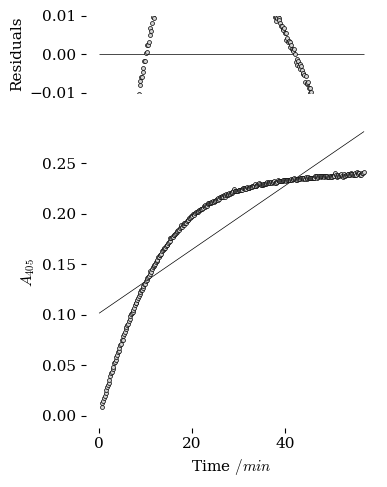

Plot saved as plots/Plate00_Cell_w_residuals_6_D.pdf


In [2]:
### Analysis of a single cell with slope and differentials

import pandas as pd
#!wget https://raw.githubusercontent.com/blinkletter/StealThisCode/main/BiochemToolbox.py
#!pip install uncertainties  # to install 'Uncertainties' package in Colab. 
import BiochemToolbox as BT
import numpy as np

data_name = "data1/data/plate00"
BT.plot_w_residuals(data_name, "6", "D", 
                      Fraction_time_span = 0.95,
                      plot_file = "plots/Plate00_Cell_w_residuals",
                      fancy = True)